In [1]:
import pandas as pd
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc


C:\Users\Javi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random

def replace_ambiguous_bases(sequence):
    def resolve_ambiguity(code):
        if code == 'R':
            return random.choice(['A', 'G'])
        elif code == 'Y':
            return random.choice(['C', 'T'])
        elif code == 'S':
            return random.choice(['G', 'C'])
        elif code == 'W':
            return random.choice(['A', 'T'])
        elif code == 'K':
            return random.choice(['G', 'T'])
        elif code == 'M':
            return random.choice(['A', 'C'])
        elif code == 'B':
            return random.choice(['C', 'G', 'T'])
        elif code == 'D':
            return random.choice(['A', 'G', 'T'])
        elif code == 'H':
            return random.choice(['A', 'C', 'T'])
        elif code == 'V':
            return random.choice(['A', 'C', 'G'])
        elif code == 'N':
            return random.choice(['A', 'T', 'C', 'G'])
        else:
            return code  # If the code is not an ambiguity code, return the same code
    
    resolved_sequence = ''.join(resolve_ambiguity(base) for base in sequence)
    return resolved_sequence

In [3]:
def reverse_complement(sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    reverse_seq = sequence[::-1]  # Reverse the sequence
    reverse_complement_seq = ''.join(complement[base] for base in reverse_seq)
    return reverse_complement_seq

def reverse_complement_list(sequence_list):
    reverse_complements = []
    for seq in sequence_list:
        reverse_complements.append(reverse_complement(seq))
    return reverse_complements

In [4]:
#This function gets the cgr for the sequences
def easy_cgr(dna_sequence):
  nucleotide_map = {
    "A": (1, 1),
    "T": (-1, -1),
    "C": (1, -1),
    "G": (-1, 1),
}
  values=[]
  point=(0,0)
  for nucleotide in dna_sequence:
        next_point=nucleotide_map[nucleotide]
        point=((point[0]+next_point[0])/2,(point[1]+next_point[1])/2)
        values.append(point)
  return values

In [5]:
#This function has input:
#sequence to plot that is the easy_cgr(sequence)
# plot id that is the name
# resolution that is the resolution
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plotting_cgr(sequence_to_plot,id_to_plot,resolution):

  # Define the resolution
  num_bins = resolution

  # Create a grid for the histogram
  xedges = np.linspace(-1, 1, num_bins + 1)
  yedges = np.linspace(-1, 1, num_bins + 1)

  # Create a 2D histogram
  hist, _, _ = np.histogram2d([p[0] for p in sequence_to_plot], [p[1] for p in sequence_to_plot], bins=[xedges, yedges])

  # Create a custom colormap spanning from light gray to dark gray
  colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
  cmap_name = "custom_gray"
  custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

  # Create a figure
  plt.figure()

  # Display the 2D histogram with the custom colormap
  plt.imshow(hist.T, cmap=custom_cmap, extent=[-1, 1, -1, 1], origin='lower', interpolation='nearest', aspect='auto')

  # Calculate coordinates for labels
  plt.xticks([])
  plt.yticks([])
  x_margin, y_margin = 0.05, 0.05
  label_coordinates = {
      "A": (1+ x_margin, 1 +y_margin),
      "T": (-1 - x_margin, -1-y_margin),
      "C": (1 + x_margin, -1 -y_margin),
      "G": (-1 - x_margin, 1 + y_margin),
  }

  # Add labels outside the grid
  for letter, (x, y) in label_coordinates.items():
      plt.text(x, y, letter, ha='center', va='center', fontsize=15, color='black')
  # Show the plot
  plt.title('CGR for '+id_to_plot)
  plt.grid(False)  # Turn off grid lines
  plt.show()

In [6]:
#This function reads the file when usingantibiotic resistance genes
import re

def read_antibiotic_resistance_genes(fasta_file_path):
    # Initialize lists to store sequence data
    sequence_ids = []
    sequences = []
    terms_inside_brackets = []  # Initialize a list to store terms inside brackets

    # Define a regular expression pattern to match text inside square brackets
    pattern = r'\[([^]]+)\]'

    # Open the FASTA file for reading
    with open(fasta_file_path, "r") as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace

            # Check if the line is an ID line (starts with '>')
            if line.startswith(">"):
                # If it's not the first sequence, process the previous one
                if sequence_ids:
                    term_inside_brackets = re.search(pattern, sequence_ids[-1]).group(1)
                    terms_inside_brackets.append(term_inside_brackets)  # Append to the list
                # Extract the sequence ID from the ID line
                sequence_ids.append(line[1:])
                sequences.append("")  # Reset the sequence
            else:
                # Append the line to the sequence
                sequences[-1] += line

    # Process the last sequence in the file
    if sequence_ids:
        term_inside_brackets = re.search(pattern, sequence_ids[-1]).group(1)
        terms_inside_brackets.append(term_inside_brackets)

    return sequences, terms_inside_brackets

In [7]:
from Bio import SeqIO

def read_fasta_patients(file_path):
    sequence_ids = []
    sequences = []
    
    try:
        with open(file_path, "r") as fasta_file:
            fasta_sequences = SeqIO.parse(fasta_file, "fasta")
            
            for seq_record in fasta_sequences:
                sequence_ids.append(seq_record.id)
                sequences.append(str(seq_record.seq))
    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
    
    return sequences, sequence_ids


In [8]:
#This function has input:
#sequence to plot that is the easy_cgr(sequence)
# plot id that is the name
# resolution that is the resolution
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plotting_cgr(sequence_to_plot,id_to_plot,resolution):

  # Define the resolution
  num_bins = resolution

  # Create a grid for the histogram
  xedges = np.linspace(-1, 1, num_bins + 1)
  yedges = np.linspace(-1, 1, num_bins + 1)

  # Create a 2D histogram
  hist, _, _ = np.histogram2d([p[0] for p in sequence_to_plot], [p[1] for p in sequence_to_plot], bins=[xedges, yedges])

  # Create a custom colormap spanning from light gray to dark gray
  colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
  cmap_name = "custom_gray"
  custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

  # Create a figure
  plt.figure()

  # Display the 2D histogram with the custom colormap
  plt.imshow(hist.T, cmap=custom_cmap, extent=[-1, 1, -1, 1], origin='lower', interpolation='nearest', aspect='auto')

  # Calculate coordinates for labels
  plt.xticks([])
  plt.yticks([])
  x_margin, y_margin = 0.05, 0.05
  label_coordinates = {
      "A": (1+ x_margin, 1 +y_margin),
      "T": (-1 - x_margin, -1-y_margin),
      "C": (1 + x_margin, -1 -y_margin),
      "G": (-1 - x_margin, 1 + y_margin),
  }

  # Add labels outside the grid
  for letter, (x, y) in label_coordinates.items():
      plt.text(x, y, letter, ha='center', va='center', fontsize=15, color='black')
  # Show the plot
  plt.title('CGR for '+id_to_plot)
  plt.grid(False)  # Turn off grid lines
  plt.show()


In [9]:
import random

def replace_ambiguous_bases(sequence):
    def resolve_ambiguity(code):
        if code == 'R':
            return random.choice(['A', 'G'])
        elif code == 'Y':
            return random.choice(['C', 'T'])
        elif code == 'S':
            return random.choice(['G', 'C'])
        elif code == 'W':
            return random.choice(['A', 'T'])
        elif code == 'K':
            return random.choice(['G', 'T'])
        elif code == 'M':
            return random.choice(['A', 'C'])
        elif code == 'B':
            return random.choice(['C', 'G', 'T'])
        elif code == 'D':
            return random.choice(['A', 'G', 'T'])
        elif code == 'H':
            return random.choice(['A', 'C', 'T'])
        elif code == 'V':
            return random.choice(['A', 'C', 'G'])
        elif code == 'N':
            return random.choice(['A', 'T', 'C', 'G'])
        else:
            return code  # If the code is not an ambiguity code, return the same code
    
    resolved_sequence = ''.join(resolve_ambiguity(base) for base in sequence)
    return resolved_sequence

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def generate_cgr_and_save(sequence_to_plot, kmeres, output_filename):
    # Define the resolution
    num_bins = 2 ** kmeres

    # Create a grid for the histogram
    xedges = np.linspace(-1, 1, num_bins + 1)
    yedges = np.linspace(-1, 1, num_bins + 1)

    # Create a 2D histogram
    hist, _, _ = np.histogram2d(
        [p[0] for p in sequence_to_plot],
        [p[1] for p in sequence_to_plot],
        bins=[xedges, yedges]
    )

    # Create a custom colormap spanning from light gray to dark gray
    colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
    cmap_name = "custom_gray"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

    # Create a square figure with the desired size in inches
    dpi = 100
    fig, ax = plt.subplots(figsize=(84 / dpi, 84 / dpi), dpi=dpi)

    # Plot the histogram using imshow and set the extent to specify the image size
    ax.imshow(
        hist.T,
        cmap=custom_cmap,
        origin='lower',
        extent=[-1, 1, -1, 1],  # Setting extent to create a 100x100 pixel image
        interpolation='nearest'  # Optional: adjust the interpolation method
    )

    # Turn off the axis
    ax.axis('off')

    # Save the figure directly as an image using matplotlib.pyplot.savefig
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.close()

# Your remaining function remains unchanged
def generate_and_save_cgr_images(sequences, ids, output_dir, kmeres):
    # Create the output directory if it doesn't exist
    

    for i, (sequence, label) in enumerate(zip(sequences, ids)):
        # Generate the image filename based on the class label and sequence index
        image_filename = os.path.join(output_dir, f"{i}_{label}.png")

        # Generate and save the CGR image
        generate_cgr_and_save(sequence, kmeres, image_filename)

In [11]:

def read_fasta_ARG(file_name):
    sequences = []
    with open(file_name, 'r') as file:
        sequence_id = ''
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id != '':
                    sequences.append(sequence_id.split('|') + [sequence])
                sequence_id = line[1:]
                sequence = ''
            else:
                sequence += line
        if sequence_id != '':
            sequences.append(sequence_id.split('|') + [sequence])
    return sequences

### Load images

### PATIENTS

In [23]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_1"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_1 = []
ids_patient_1 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_1.append(img_array)
    # Extract the label from the image filename
    ids_patient_1.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 10981


In [24]:
print( "these lenghts should be the same ",len(images_patient_1),", ",len(ids_patient_1))

these lenghts should be the same  10981 ,  10981


In [25]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_2"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_2 = []
ids_patient_2 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_2.append(img_array)
    # Extract the label from the image filename
    ids_patient_2.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 15000


In [26]:
print( "these lenghts should be the same ",len(images_patient_2),", ",len(ids_patient_2))

these lenghts should be the same  15000 ,  15000


In [27]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_4"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_4 = []
ids_patient_4 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_4.append(img_array)
    # Extract the label from the image filename
    ids_patient_4.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 9172


In [28]:
print( "these lenghts should be the same ",len(images_patient_4),", ",len(ids_patient_4))

these lenghts should be the same  9172 ,  9172


In [29]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_5"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_5 = []
ids_patient_5 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_5.append(img_array)
    # Extract the label from the image filename
    ids_patient_5.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 15000


In [30]:
print( "these lenghts should be the same ",len(images_patient_5),", ",len(ids_patient_5))

these lenghts should be the same  15000 ,  15000


In [31]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_6"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_6 = []
ids_patient_6 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_6.append(img_array)
    # Extract the label from the image filename
    ids_patient_6.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 10267


In [32]:
print( "these lenghts should be the same ",len(images_patient_6),", ",len(ids_patient_6))

these lenghts should be the same  10267 ,  10267


In [33]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_11"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_11 = []
ids_patient_11 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_11.append(img_array)
    # Extract the label from the image filename
    ids_patient_11.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 10022


In [34]:
print( "these lenghts should be the same ",len(images_patient_11),", ",len(ids_patient_11))

these lenghts should be the same  10022 ,  10022


In [35]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_12"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_12 = []
ids_patient_12 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_12.append(img_array)
    # Extract the label from the image filename
    ids_patient_12.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 8445


In [36]:
print( "these lenghts should be the same ",len(images_patient_12),", ",len(ids_patient_12))

these lenghts should be the same  8445 ,  8445


In [37]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_13"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_13 = []
ids_patient_13 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_13.append(img_array)
    # Extract the label from the image filename
    ids_patient_13.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 12053


In [38]:
print( "these lenghts should be the same ",len(images_patient_13),", ",len(ids_patient_13))

these lenghts should be the same  12053 ,  12053


In [39]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_14"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_14 = []
ids_patient_14 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_14.append(img_array)
    # Extract the label from the image filename
    ids_patient_14.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 16327


In [40]:
print( "these lenghts should be the same ",len(images_patient_14),", ",len(ids_patient_14))

these lenghts should be the same  16327 ,  16327


In [41]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_15"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_15 = []
ids_patient_15 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_15.append(img_array)
    # Extract the label from the image filename
    ids_patient_15.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 13487


In [42]:
print( "these lenghts should be the same ",len(images_patient_15),", ",len(ids_patient_15))

these lenghts should be the same  13487 ,  13487


# HEALTHY

In [23]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_11"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_11 = []
ids_healthy_11 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_11.append(img_array)
    # Extract the label from the image filename
    ids_healthy_11.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 14512


In [24]:
print( "these lenghts should be the same ",len(images_healthy_11),", ",len(ids_healthy_11))

these lenghts should be the same  14512 ,  14512


In [25]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_12"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_12 = []
ids_healthy_12 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_12.append(img_array)
    # Extract the label from the image filename
    ids_healthy_12.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 7162


In [26]:
print( "these lenghts should be the same ",len(images_healthy_12),", ",len(ids_healthy_12))

these lenghts should be the same  7162 ,  7162


In [27]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_13"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_13 = []
ids_healthy_13 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_13.append(img_array)
    # Extract the label from the image filename
    ids_healthy_13.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 12271


In [28]:
print( "these lenghts should be the same ",len(images_healthy_13),", ",len(ids_healthy_13))

these lenghts should be the same  12271 ,  12271


In [29]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_14"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_14 = []
ids_healthy_14 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_14.append(img_array)
    # Extract the label from the image filename
    ids_healthy_14.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 10941


In [30]:
print( "these lenghts should be the same ",len(images_healthy_14),", ",len(ids_healthy_14))

these lenghts should be the same  10941 ,  10941


In [31]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_15"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_15 = []
ids_healthy_15 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_15.append(img_array)
    # Extract the label from the image filename
    ids_healthy_15.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 10741


In [32]:
print( "these lenghts should be the same ",len(images_healthy_15),", ",len(ids_healthy_15))

these lenghts should be the same  10741 ,  10741


In [33]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_16"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_16 = []
ids_healthy_16 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_16.append(img_array)
    # Extract the label from the image filename
    ids_healthy_16.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 4965


In [34]:
print( "these lenghts should be the same ",len(images_healthy_16),", ",len(ids_healthy_16))

these lenghts should be the same  4965 ,  4965


In [35]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_17"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_17 = []
ids_healthy_17 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_17.append(img_array)
    # Extract the label from the image filename
    ids_healthy_17.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 6671


In [36]:
print( "these lenghts should be the same ",len(images_healthy_17),", ",len(ids_healthy_17))

these lenghts should be the same  6671 ,  6671


In [37]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_18"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_18 = []
ids_healthy_18 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_18.append(img_array)
    # Extract the label from the image filename
    ids_healthy_18.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 9216


In [38]:
print( "these lenghts should be the same ",len(images_healthy_18),", ",len(ids_healthy_18))

these lenghts should be the same  9216 ,  9216


In [39]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_19"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_19 = []
ids_healthy_19 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_19.append(img_array)
    # Extract the label from the image filename
    ids_healthy_19.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 14460


In [40]:
print( "these lenghts should be the same ",len(images_healthy_19),", ",len(ids_healthy_19))

these lenghts should be the same  14460 ,  14460


In [41]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_20"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_20 = []
ids_healthy_20 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_20.append(img_array)
    # Extract the label from the image filename
    ids_healthy_20.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 14893


In [42]:
print( "these lenghts should be the same ",len(images_healthy_20),", ",len(ids_healthy_20))

these lenghts should be the same  14893 ,  14893


### Get datasets together

#### Patients 

In [43]:
print("Length of images_patient_1:", len(images_patient_1))
print("Length of images_patient_2:", len(images_patient_2))
print("Length of images_patient_4:", len(images_patient_4))
print("Length of images_patient_5:", len(images_patient_5))

# Combine the images and IDs from different directories
images_patient_data_1 = images_patient_1 + images_patient_2 + images_patient_4 + images_patient_5
labels_patient_data_1 = ids_patient_1 + ids_patient_2 + ids_patient_4 + ids_patient_5

# Print lengths after combining
print("Length of images_combined:", len(images_patient_data_1))
print("Length of ids_combined:", len(labels_patient_data_1))

Length of images_patient_1: 10981
Length of images_patient_2: 15000
Length of images_patient_4: 9172
Length of images_patient_5: 15000
Length of images_combined: 50153
Length of ids_combined: 50153


In [44]:
print("Length of images_patient_6:", len(images_patient_6))
print("Length of images_patient_11:", len(images_patient_11))
print("Length of images_patient_12:", len(images_patient_12))
print("Length of images_patient_13:", len(images_patient_13))

# Combine the images and IDs from different directories
images_patient_data_2 = images_patient_6 + images_patient_11 + images_patient_12 + images_patient_13
labels_patient_data_2 = ids_patient_6 + ids_patient_11 + ids_patient_12 + ids_patient_13

# Print lengths after combining
print("Length of images_combined:", len(images_patient_data_2))
print("Length of ids_combined:", len(labels_patient_data_2))

Length of images_patient_6: 10267
Length of images_patient_11: 10022
Length of images_patient_12: 8445
Length of images_patient_13: 12053
Length of images_combined: 40787
Length of ids_combined: 40787


In [45]:
print("Length of images_patient_14:", len(images_patient_14))
print("Length of images_patient_15:", len(images_patient_15))
print("Length of images_patient_4:", len(images_patient_4))
print("Length of images_patient_13:", len(images_patient_13))

# Combine the images and IDs from different directories
images_patient_data_3 = images_patient_14 + images_patient_15 + images_patient_4 + images_patient_13
labels_patient_data_3 = ids_patient_14 + ids_patient_15 + ids_patient_4 + ids_patient_13

# Print lengths after combining
print("Length of images_combined:", len(images_patient_data_3))
print("Length of ids_combined:", len(labels_patient_data_3))

Length of images_patient_14: 16327
Length of images_patient_15: 13487
Length of images_patient_4: 9172
Length of images_patient_13: 12053
Length of images_combined: 51039
Length of ids_combined: 51039


#### Healthy 

In [43]:
print("Length of images_healthy_11:", len(images_healthy_11))
print("Length of images_healthy_12:", len(images_healthy_12))
print("Length of images_healthy_13:", len(images_healthy_13))
print("Length of images_healthy_14:", len(images_healthy_14))

# Combine the images and IDs from different directories
images_healthy_data_1 = images_healthy_11 + images_healthy_12 + images_healthy_13 + images_healthy_14
labels_healthy_data_1 = ids_healthy_11 + ids_healthy_12 + ids_healthy_13 + ids_healthy_14

# Print lengths after combining
print("Length of images_combined:", len(images_healthy_data_1))
print("Length of ids_combined:", len(labels_healthy_data_1))

Length of images_healthy_11: 14512
Length of images_healthy_12: 7162
Length of images_healthy_13: 12271
Length of images_healthy_14: 10941
Length of images_combined: 44886
Length of ids_combined: 44886


In [44]:
print("Length of images_healthy_15:", len(images_healthy_15))
print("Length of images_healthy_16:", len(images_healthy_16))
print("Length of images_healthy_17:", len(images_healthy_17))
print("Length of images_healthy_18:", len(images_healthy_18))

# Combine the images and IDs from different directories
images_healthy_data_2 = images_healthy_15 + images_healthy_16 + images_healthy_17 + images_healthy_18
labels_healthy_data_2 = ids_healthy_15 + ids_healthy_16 + ids_healthy_17 + ids_healthy_18

# Print lengths after combining
print("Length of images_combined:", len(images_healthy_data_2))
print("Length of ids_combined:", len(labels_healthy_data_2))

Length of images_healthy_15: 10741
Length of images_healthy_16: 4965
Length of images_healthy_17: 6671
Length of images_healthy_18: 9216
Length of images_combined: 31593
Length of ids_combined: 31593


In [45]:
print("Length of images_healthy_19:", len(images_healthy_19))
print("Length of images_healthy_20:", len(images_healthy_20))
print("Length of images_healthy_13:", len(images_healthy_13))
print("Length of images_healthy_17:", len(images_healthy_17))

# Combine the images and IDs from different directories
images_healthy_data_3 = images_healthy_19 + images_healthy_20 + images_healthy_13 + images_healthy_17
labels_healthy_data_3 = ids_healthy_19 + ids_healthy_20 + ids_healthy_13 + ids_healthy_17

# Print lengths after combining
print("Length of images_combined:", len(images_healthy_data_3))
print("Length of ids_combined:", len(labels_healthy_data_3))

Length of images_healthy_19: 14460
Length of images_healthy_20: 14893
Length of images_healthy_13: 12271
Length of images_healthy_17: 6671
Length of images_combined: 48295
Length of ids_combined: 48295


###  DELEATE VARIABLES FOR MORE SPACE

In [46]:
del images_patient_1
del images_patient_2
del images_patient_4
del images_patient_5
del images_patient_6
del images_patient_11
del images_patient_12
del images_patient_13
del images_patient_14
del images_patient_15

In [47]:
del ids_patient_1
del ids_patient_2
del ids_patient_4
del ids_patient_5
del ids_patient_6
del ids_patient_11
del ids_patient_12
del ids_patient_13
del ids_patient_14
del ids_patient_15

In [46]:
del images_healthy_11
del images_healthy_12
del images_healthy_13
del images_healthy_14
del images_healthy_15
del images_healthy_16
del images_healthy_17
del images_healthy_18
del images_healthy_19
del images_healthy_20

In [47]:
del ids_healthy_11
del ids_healthy_12
del ids_healthy_13
del ids_healthy_14
del ids_healthy_15
del ids_healthy_16
del ids_healthy_17
del ids_healthy_18
del ids_healthy_19
del ids_healthy_20

### LOAD ARG PATIENT

In [48]:
dataset_dir_1 = "ARG_and_inv_conjugates_images_synthetic_patient"

In [49]:


# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_ARG = []
labels_ARG = []

In [50]:
# Load and preprocess images from directory 1 (label 1)
for image_file in os.listdir(dataset_dir_1): 
    # Check if the file is an image file
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Load and preprocess the image
        img = load_img(os.path.join(dataset_dir_1, image_file), target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        # Append the image and class label to the lists
        images_ARG.append(img_array)
        labels_ARG.append(1)
    else:
        print("Skipping non-image file:", image_file)



Skipping non-image file: CARB-21_[Vibrio_parahaemolyticus_O1
Skipping non-image file: cpxA_[Escherichia_coli_O157
Skipping non-image file: Ecol_LamB_[Escherichia_coli_O157
Skipping non-image file: Ecol_mipA_[Escherichia_coli_O157
Skipping non-image file: Ecol_rpoB_RIF_[Escherichia_coli_O157
Skipping non-image file: evgA_[Escherichia_coli_O157
Skipping non-image file: gadW_[Escherichia_coli_O25b
Skipping non-image file: H-NS_[Escherichia_coli_O157
Skipping non-image file: LEN-10_[Klebsiella_variicola_CAG
Skipping non-image file: mdtG_[Escherichia_coli_O139
Skipping non-image file: rosA_[Yersinia_enterocolitica_(type_O
Skipping non-image file: rosB_[Yersinia_enterocolitica_(type_O


## Patients

### Final Dataset 1

In [51]:
# Convert lists to NumPy arrays
images_patient_classification_1 = np.array(images_patient_data_1+images_ARG)
labels_patient_classification_1 = np.array(labels_patient_data_1+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_patient_classification_1))
print("Number of loaded labels:", len(labels_patient_classification_1))
print("Sample class labels:", labels_patient_classification_1[:5])

Number of loaded images: 60265
Number of loaded labels: 60265
Sample class labels: [0 0 0 0 0]


In [52]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_patient_classification_1:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_patient_classification_1))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 60265
Number of images with label 0: 50153
Number of images with label 1: 10112


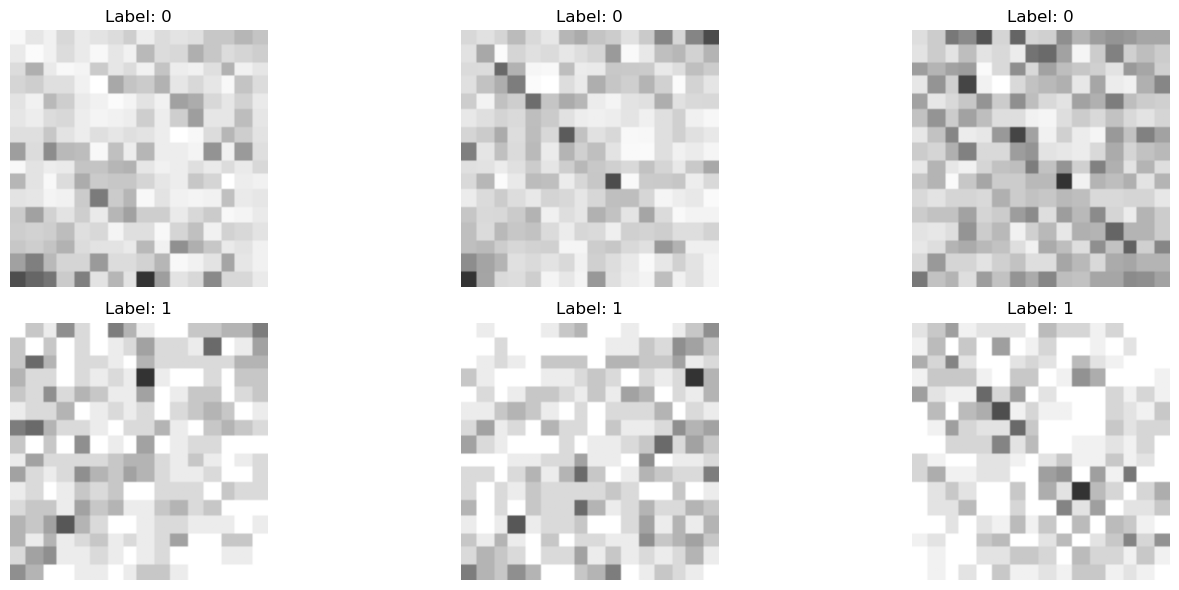

In [53]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_patient_classification_1, labels_patient_classification_1)



### Final Dataset 2

In [54]:
# Convert lists to NumPy arrays
images_patient_classification_2 = np.array(images_patient_data_2+images_ARG)
labels_patient_classification_2 = np.array(labels_patient_data_2+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_patient_classification_2))
print("Number of loaded labels:", len(labels_patient_classification_2))
print("Sample class labels:", labels_patient_classification_2[:5])

Number of loaded images: 50899
Number of loaded labels: 50899
Sample class labels: [0 0 0 0 0]


In [55]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_patient_classification_2:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_patient_classification_2))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 50899
Number of images with label 0: 40787
Number of images with label 1: 10112


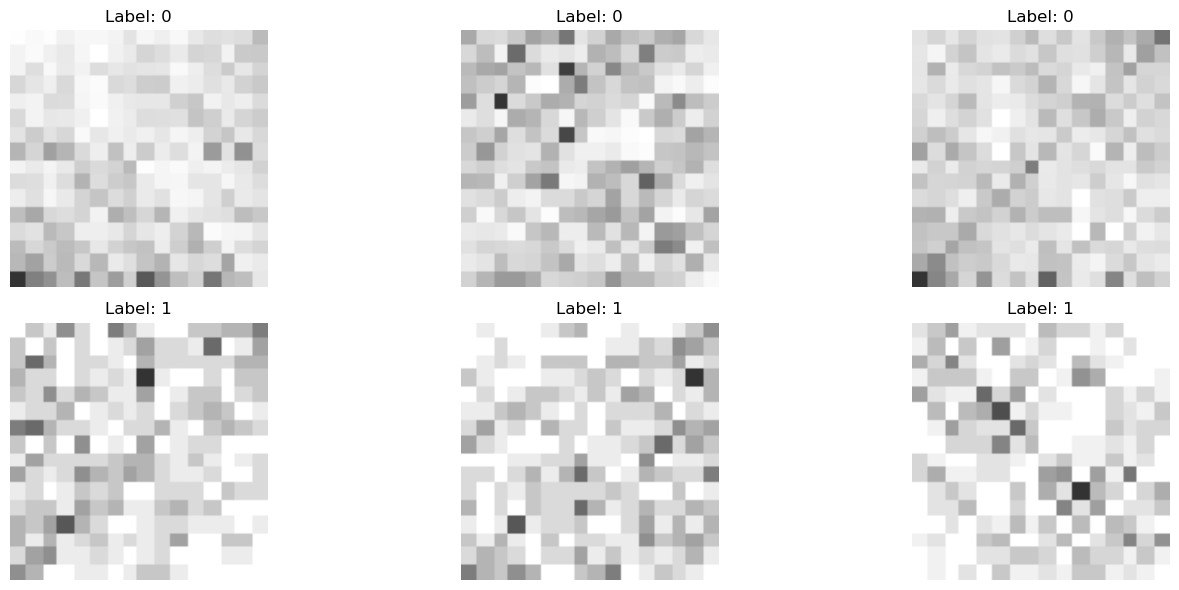

In [56]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_patient_classification_2, labels_patient_classification_2)



### Final Dataset 3

In [57]:
# Convert lists to NumPy arrays
images_patient_classification_3 = np.array(images_patient_data_3+images_ARG)
labels_patient_classification_3 = np.array(labels_patient_data_3+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_patient_classification_3))
print("Number of loaded labels:", len(labels_patient_classification_3))
print("Sample class labels:", labels_patient_classification_3[:5])

Number of loaded images: 61151
Number of loaded labels: 61151
Sample class labels: [0 0 0 0 0]


In [58]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_patient_classification_3:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_patient_classification_3))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 61151
Number of images with label 0: 51039
Number of images with label 1: 10112


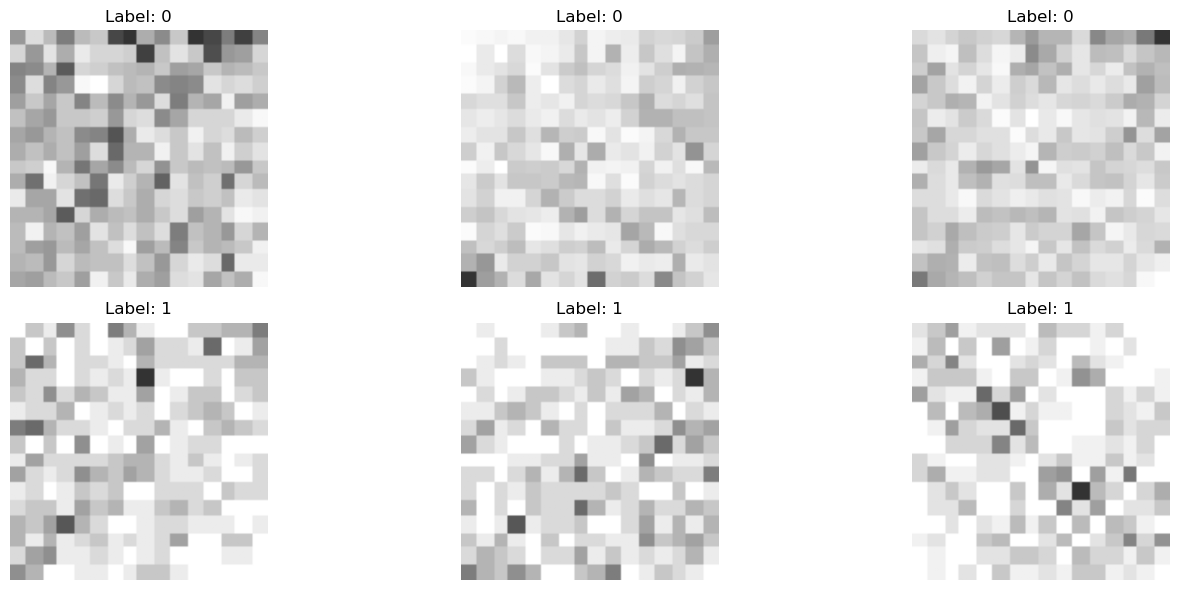

In [59]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_patient_classification_3, labels_patient_classification_3)



### Delete variables to free space

In [60]:
del images_patient_data_1
del labels_patient_data_1
del images_patient_data_2
del labels_patient_data_2
del images_patient_data_3
del labels_patient_data_3

## Healhty

### LOAD ARG PATIENT

In [48]:
dataset_dir_1 = "ARG_and_inv_conjugates_images_synthetic_healthy"

In [49]:


# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_ARG = []
labels_ARG = []

In [50]:
# Load and preprocess images from directory 1 (label 1)
for image_file in os.listdir(dataset_dir_1): 
    # Check if the file is an image file
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Load and preprocess the image
        img = load_img(os.path.join(dataset_dir_1, image_file), target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        # Append the image and class label to the lists
        images_ARG.append(img_array)
        labels_ARG.append(1)
    else:
        print("Skipping non-image file:", image_file)



Skipping non-image file: CARB-21_[Vibrio_parahaemolyticus_O1
Skipping non-image file: cpxA_[Escherichia_coli_O157
Skipping non-image file: Ecol_LamB_[Escherichia_coli_O157
Skipping non-image file: Ecol_mipA_[Escherichia_coli_O157
Skipping non-image file: Ecol_rpoB_RIF_[Escherichia_coli_O157
Skipping non-image file: evgA_[Escherichia_coli_O157
Skipping non-image file: gadW_[Escherichia_coli_O25b
Skipping non-image file: H-NS_[Escherichia_coli_O157
Skipping non-image file: LEN-10_[Klebsiella_variicola_CAG
Skipping non-image file: mdtG_[Escherichia_coli_O139
Skipping non-image file: rosA_[Yersinia_enterocolitica_(type_O
Skipping non-image file: rosB_[Yersinia_enterocolitica_(type_O


### Final Dataset 1

In [51]:
# Convert lists to NumPy arrays
images_healthy_classification_1 = np.array(images_healthy_data_1+images_ARG)
labels_healthy_classification_1 = np.array(labels_healthy_data_1+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_healthy_classification_1))
print("Number of loaded labels:", len(labels_healthy_classification_1))
print("Sample class labels:", labels_healthy_classification_1[:5])

Number of loaded images: 54998
Number of loaded labels: 54998
Sample class labels: [0 0 0 0 0]


In [52]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_healthy_classification_1:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_healthy_classification_1))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 54998
Number of images with label 0: 44886
Number of images with label 1: 10112


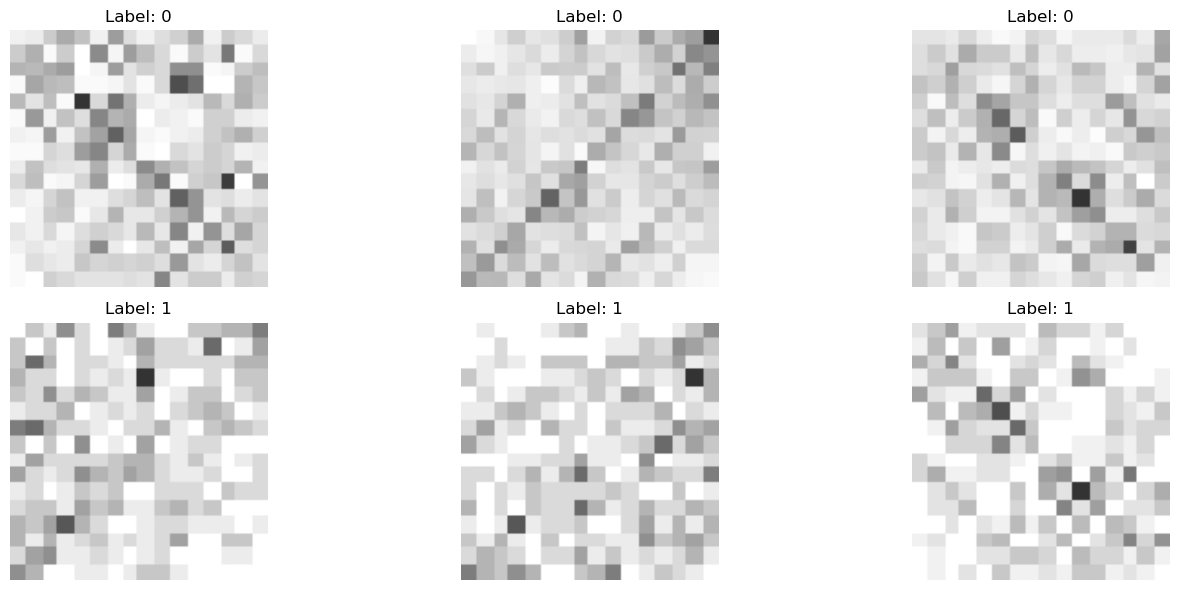

In [53]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_healthy_classification_1, labels_healthy_classification_1)



### Final Dataset 2

In [54]:
# Convert lists to NumPy arrays
images_healthy_classification_2 = np.array(images_healthy_data_2+images_ARG)
labels_healthy_classification_2 = np.array(labels_healthy_data_2+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_healthy_classification_2))
print("Number of loaded labels:", len(labels_healthy_classification_2))
print("Sample class labels:", labels_healthy_classification_2[:5])

Number of loaded images: 41705
Number of loaded labels: 41705
Sample class labels: [0 0 0 0 0]


In [55]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_healthy_classification_2:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_healthy_classification_2))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 41705
Number of images with label 0: 31593
Number of images with label 1: 10112


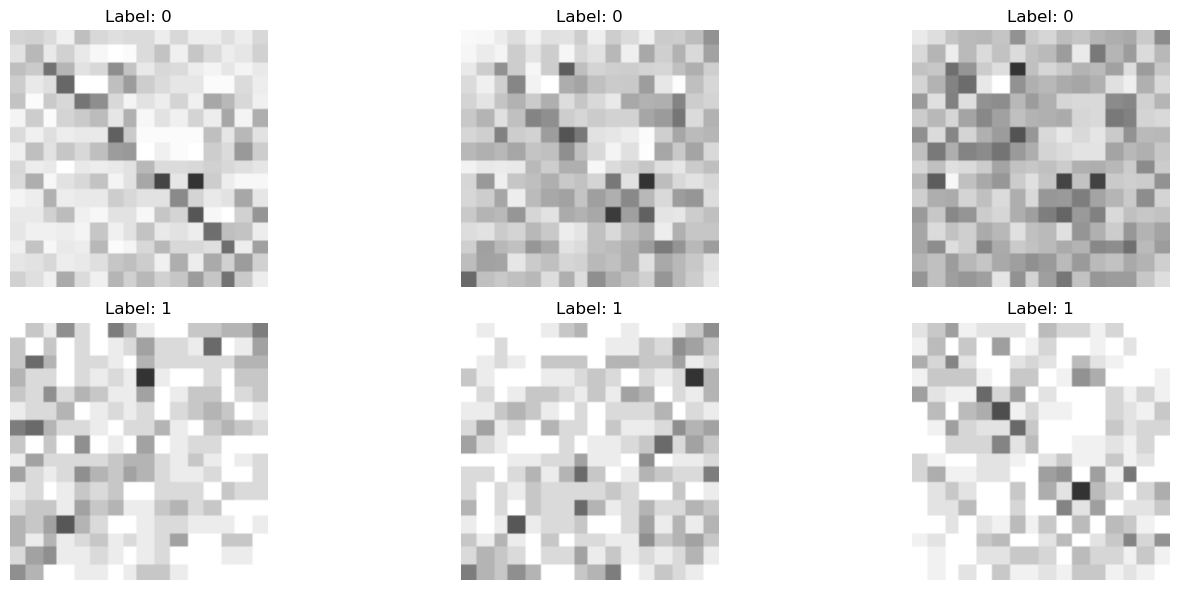

In [56]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_healthy_classification_2, labels_healthy_classification_2)



### Final Dataset 3

In [57]:
# Convert lists to NumPy arrays
images_healthy_classification_3 = np.array(images_healthy_data_3+images_ARG)
labels_healthy_classification_3 = np.array(labels_healthy_data_3+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_healthy_classification_3))
print("Number of loaded labels:", len(labels_healthy_classification_3))
print("Sample class labels:", labels_healthy_classification_3[:5])

Number of loaded images: 58407
Number of loaded labels: 58407
Sample class labels: [0 0 0 0 0]


In [59]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_healthy_classification_3:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_healthy_classification_3))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 58407
Number of images with label 0: 48295
Number of images with label 1: 10112


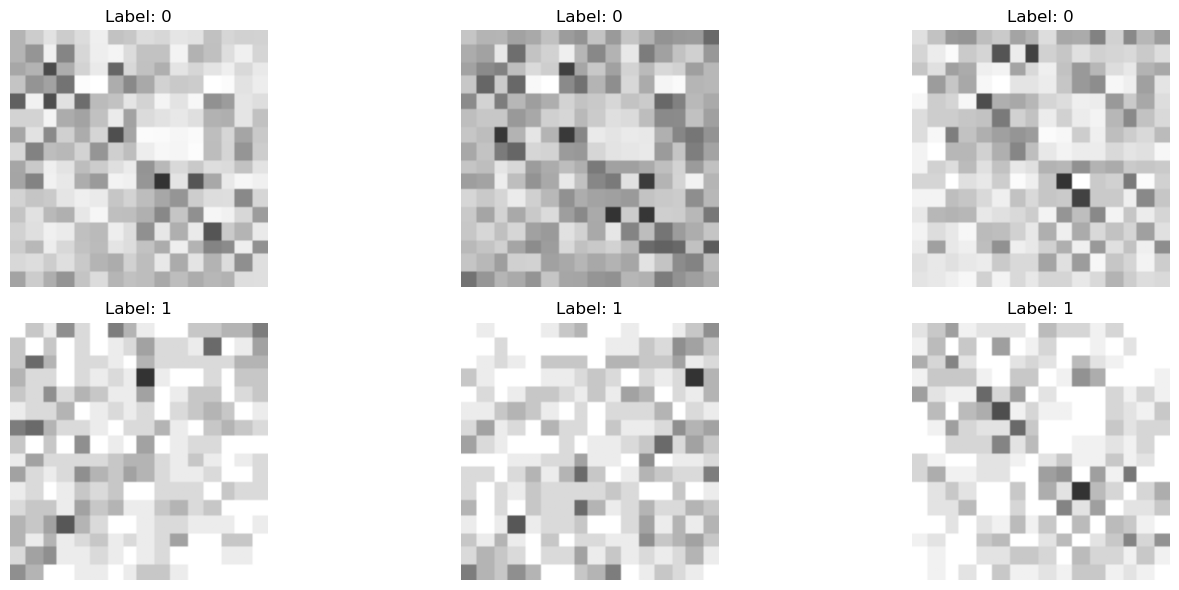

In [60]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_healthy_classification_3, labels_healthy_classification_3)



### Delete variables to free space

In [61]:
del images_healthy_data_1
del labels_healthy_data_1
del images_healthy_data_2
del labels_healthy_data_2
del images_healthy_data_3
del labels_healthy_data_3

# MODELS PATIENT

# Model 1: Data

In [61]:

train_images = images_patient_classification_1
train_labels = labels_patient_classification_1
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [62]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 40229 samples
Label 1: 7983 samples
Total samples in the training set: 48212


In [63]:
# Generic

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1507/1507 [==============================] - 243s 160ms/step - loss: 0.1115 - accuracy: 0.9613 - val_loss: 0.0874 - val_accuracy: 0.9735
Epoch 2/10
1507/1507 [==============================] - 240s 159ms/step - loss: 0.0533 - accuracy: 0.9819 - val_loss: 0.0685 - val_accuracy: 0.9743
Epoch 3/10
1507/1507 [==============================] - 240s 159ms/step - loss: 0.0387 - accuracy: 0.9866 - val_loss: 0.0487 - val_accuracy: 0.9867
Epoch 4/10
1507/1507 [==============================] - 235s 156ms/step - loss: 0.0288 - accuracy: 0.9900 - val_loss: 0.0419 - val_accuracy: 0.9871
Epoch 5/10
1507/1507 [==============================] - 238s 158ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0367 - val_accuracy: 0.9886
Epoch 6/10
1507/1507 [==============================] - 238s 158ms/step - loss: 0.0171 - accuracy: 0.9939 - val_loss: 0.0397 - val_accuracy: 0.9892
Epoch 7/10
1507/1507 [==============================] - 241s 160ms/step - loss: 0.0128 - accuracy: 0.9954 - val_

In [65]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

377/377 [==============================] - 11s 28ms/step


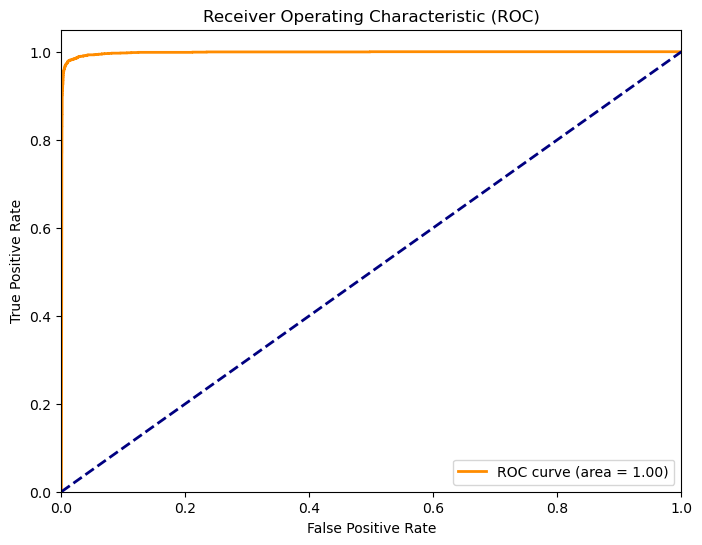

Accuracy: 0.9874
Precision: 0.9516
Recall: 0.9784
F1 Score: 0.9648
ROC-AUC Score: 0.9980


In [66]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

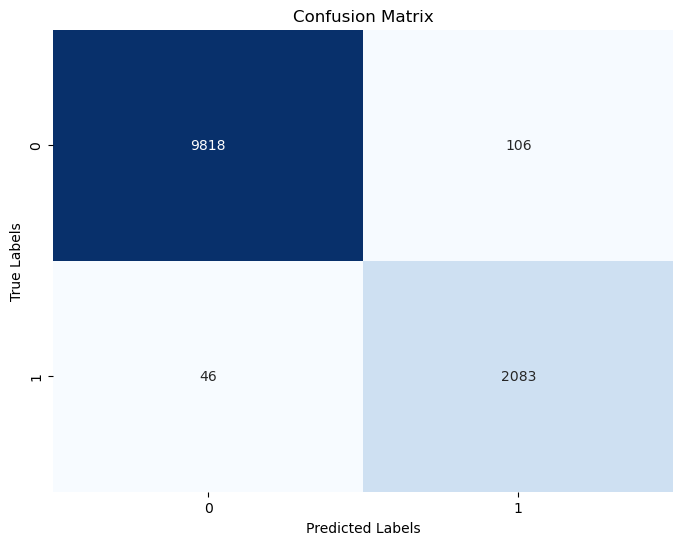

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Save the model
model_generic.save('generic_model_ARGvspatient_synthetic_1.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model 2: Data

In [69]:

train_images = images_patient_classification_2
train_labels = labels_patient_classification_2
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [70]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 32606 samples
Label 1: 8113 samples
Total samples in the training set: 40719


In [71]:
# Generic

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1273/1273 [==============================] - 204s 160ms/step - loss: 0.1426 - accuracy: 0.9497 - val_loss: 0.0662 - val_accuracy: 0.9761
Epoch 2/10
1273/1273 [==============================] - 199s 157ms/step - loss: 0.0559 - accuracy: 0.9817 - val_loss: 0.0447 - val_accuracy: 0.9849
Epoch 3/10
1273/1273 [==============================] - 199s 156ms/step - loss: 0.0384 - accuracy: 0.9872 - val_loss: 0.0400 - val_accuracy: 0.9874
Epoch 4/10
1273/1273 [==============================] - 198s 156ms/step - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.0381 - val_accuracy: 0.9880
Epoch 5/10
1273/1273 [==============================] - 202s 159ms/step - loss: 0.0223 - accuracy: 0.9922 - val_loss: 0.0410 - val_accuracy: 0.9888
Epoch 6/10
1273/1273 [==============================] - 203s 159ms/step - loss: 0.0158 - accuracy: 0.9944 - val_loss: 0.0597 - val_accuracy: 0.9857
Epoch 7/10
1273/1273 [==============================] - 201s 158ms/step - loss: 0.0120 - accuracy: 0.9958 - val_

In [73]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

319/319 [==============================] - 9s 28ms/step


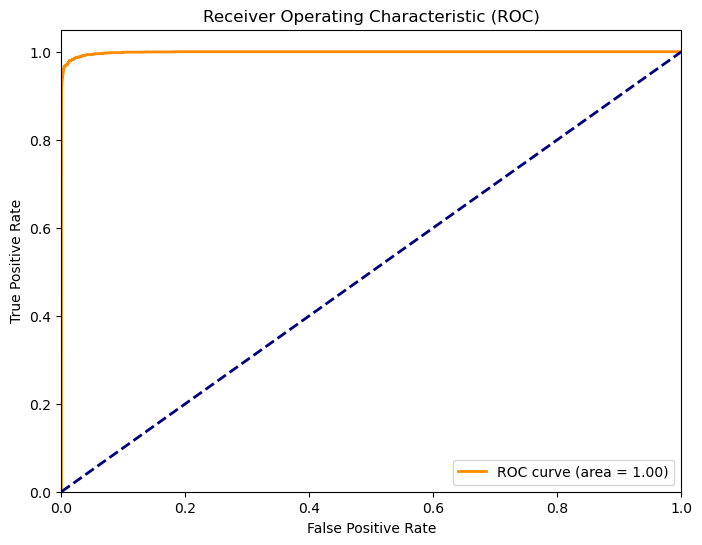

Accuracy: 0.9896
Precision: 0.9812
Recall: 0.9655
F1 Score: 0.9733
ROC-AUC Score: 0.9988


In [74]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

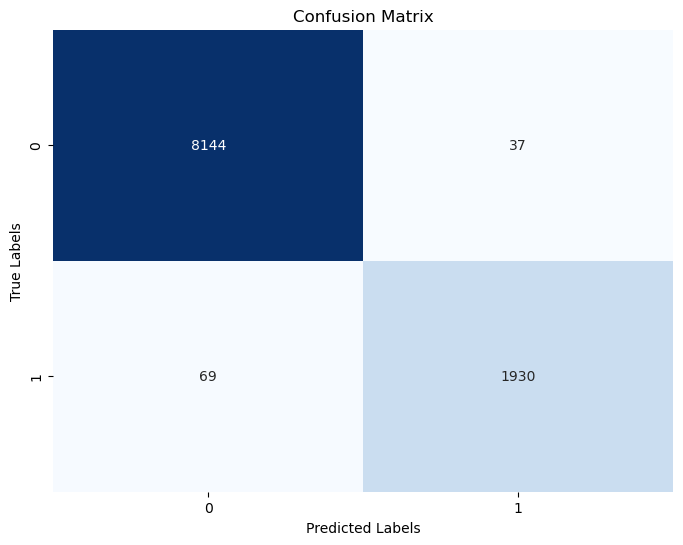

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [76]:
# Save the model
model_generic.save('generic_model_ARGvspatient_synthetic_2.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model 3: Data

In [77]:

train_images = images_patient_classification_3
train_labels = labels_patient_classification_3
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [78]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 40837 samples
Label 1: 8083 samples
Total samples in the training set: 48920


In [79]:
# Generic

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1529/1529 [==============================] - 250s 163ms/step - loss: 0.1435 - accuracy: 0.9498 - val_loss: 0.0847 - val_accuracy: 0.9756
Epoch 2/10
1529/1529 [==============================] - 242s 159ms/step - loss: 0.0584 - accuracy: 0.9807 - val_loss: 0.0567 - val_accuracy: 0.9814
Epoch 3/10
1529/1529 [==============================] - 242s 158ms/step - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.0433 - val_accuracy: 0.9855
Epoch 4/10
1529/1529 [==============================] - 239s 157ms/step - loss: 0.0317 - accuracy: 0.9897 - val_loss: 0.0462 - val_accuracy: 0.9859
Epoch 5/10
1529/1529 [==============================] - 240s 157ms/step - loss: 0.0260 - accuracy: 0.9912 - val_loss: 0.0446 - val_accuracy: 0.9850
Epoch 6/10
1529/1529 [==============================] - 239s 157ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0435 - val_accuracy: 0.9872
Epoch 7/10
1529/1529 [==============================] - 240s 157ms/step - loss: 0.0160 - accuracy: 0.9946 - val_

In [81]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

383/383 [==============================] - 12s 32ms/step


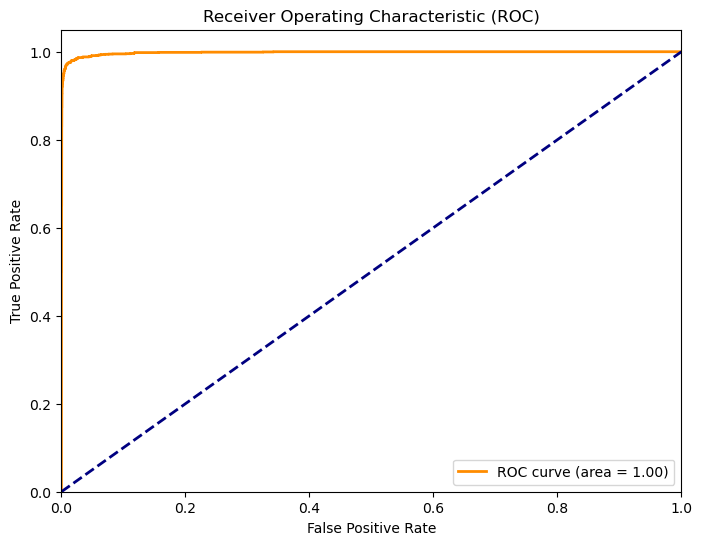

Accuracy: 0.9886
Precision: 0.9669
Recall: 0.9645
F1 Score: 0.9657
ROC-AUC Score: 0.9980


In [82]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

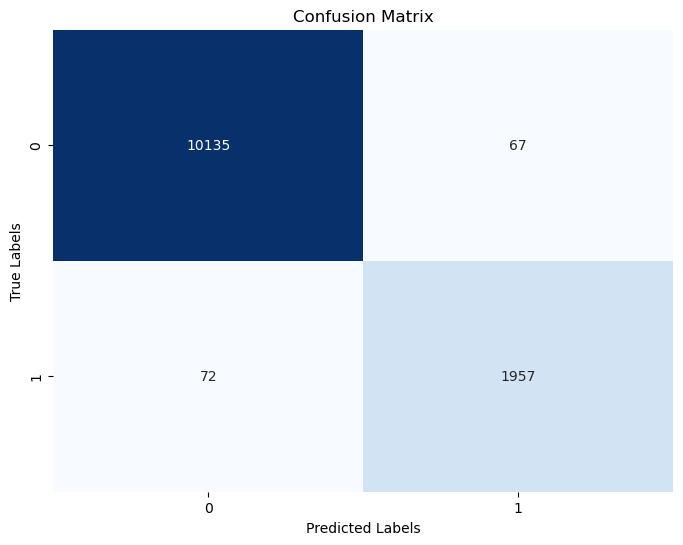

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [84]:
# Save the model
model_generic.save('generic_model_ARGvspatient_synthetic_3.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# MODELS  Healthy

# Model 1: Data

In [62]:

train_images = images_healthy_classification_1
train_labels = labels_healthy_classification_1
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [63]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 35915 samples
Label 1: 8083 samples
Total samples in the training set: 43998


In [64]:
# Generic

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1375/1375 [==============================] - 223s 160ms/step - loss: 0.1288 - accuracy: 0.9522 - val_loss: 0.0839 - val_accuracy: 0.9750
Epoch 2/10
1375/1375 [==============================] - 220s 160ms/step - loss: 0.0569 - accuracy: 0.9803 - val_loss: 0.0451 - val_accuracy: 0.9855
Epoch 3/10
1375/1375 [==============================] - 221s 161ms/step - loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.0393 - val_accuracy: 0.9871
Epoch 4/10
1375/1375 [==============================] - 224s 163ms/step - loss: 0.0283 - accuracy: 0.9907 - val_loss: 0.0309 - val_accuracy: 0.9898
Epoch 5/10
1375/1375 [==============================] - 223s 162ms/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0305 - val_accuracy: 0.9905
Epoch 6/10
1375/1375 [==============================] - 221s 161ms/step - loss: 0.0168 - accuracy: 0.9938 - val_loss: 0.0331 - val_accuracy: 0.9895
Epoch 7/10
1375/1375 [==============================] - 221s 161ms/step - loss: 0.0118 - accuracy: 0.9959 - val_

In [66]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

344/344 [==============================] - 10s 29ms/step


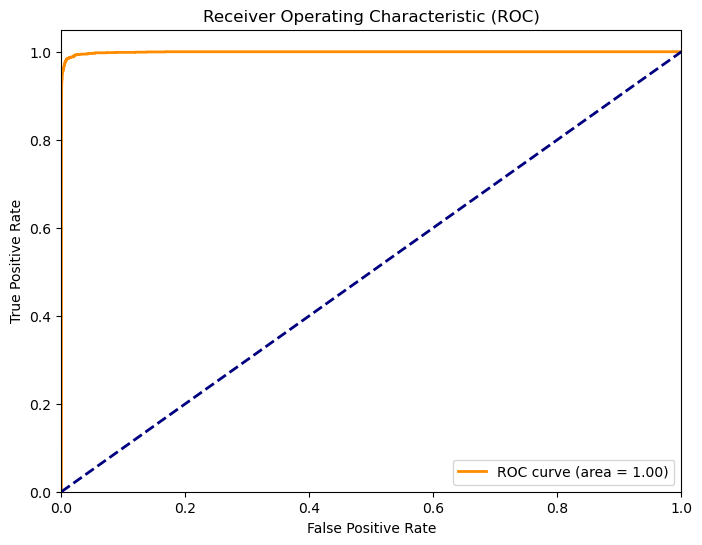

Accuracy: 0.9905
Precision: 0.9810
Recall: 0.9675
F1 Score: 0.9742
ROC-AUC Score: 0.9991


In [67]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

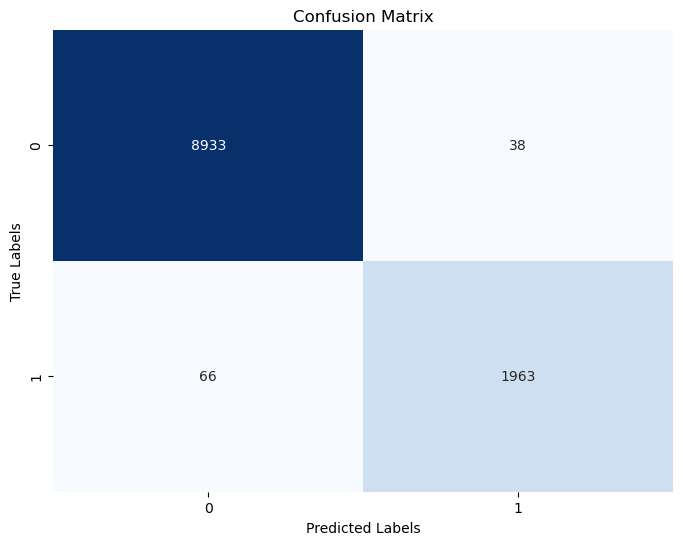

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
# Save the model
model_generic.save('generic_model_ARGvshealthy_synthetic_1.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model 2: Data

In [70]:

train_images = images_healthy_classification_2
train_labels = labels_healthy_classification_2
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [71]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 25227 samples
Label 1: 8137 samples
Total samples in the training set: 33364


In [72]:
# Generic

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1043/1043 [==============================] - 169s 161ms/step - loss: 0.1307 - accuracy: 0.9511 - val_loss: 0.0733 - val_accuracy: 0.9747
Epoch 2/10
1043/1043 [==============================] - 162s 155ms/step - loss: 0.0591 - accuracy: 0.9808 - val_loss: 0.0513 - val_accuracy: 0.9821
Epoch 3/10
1043/1043 [==============================] - 169s 162ms/step - loss: 0.0417 - accuracy: 0.9863 - val_loss: 0.0379 - val_accuracy: 0.9881
Epoch 4/10
1043/1043 [==============================] - 169s 162ms/step - loss: 0.0350 - accuracy: 0.9880 - val_loss: 0.0432 - val_accuracy: 0.9853
Epoch 5/10
1043/1043 [==============================] - 168s 161ms/step - loss: 0.0255 - accuracy: 0.9910 - val_loss: 0.0340 - val_accuracy: 0.9896
Epoch 6/10
1043/1043 [==============================] - 170s 163ms/step - loss: 0.0196 - accuracy: 0.9930 - val_loss: 0.0371 - val_accuracy: 0.9886
Epoch 7/10
1043/1043 [==============================] - 171s 164ms/step - loss: 0.0170 - accuracy: 0.9940 - val_

In [74]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

261/261 [==============================] - 8s 30ms/step


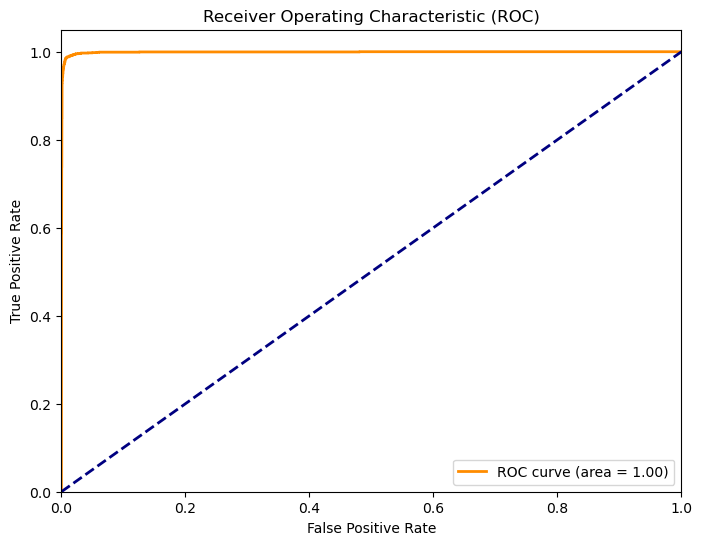

Accuracy: 0.9909
Precision: 0.9817
Recall: 0.9797
F1 Score: 0.9807
ROC-AUC Score: 0.9990


In [75]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

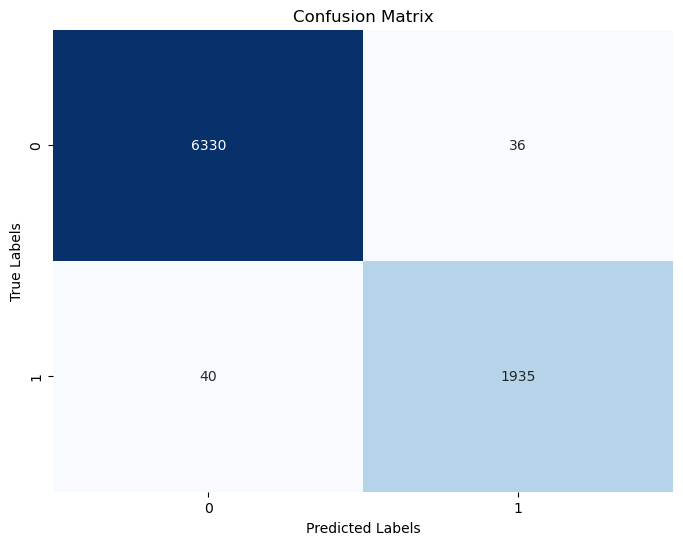

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Save the model
model_generic.save('generic_model_ARGvshealthy_synthetic_2.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model 3: Data

In [78]:

train_images = images_healthy_classification_3
train_labels = labels_healthy_classification_3
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [79]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 38676 samples
Label 1: 8049 samples
Total samples in the training set: 46725


In [80]:
# Generic

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1461/1461 [==============================] - 247s 168ms/step - loss: 0.1054 - accuracy: 0.9630 - val_loss: 0.0654 - val_accuracy: 0.9817
Epoch 2/10
1461/1461 [==============================] - 237s 162ms/step - loss: 0.0520 - accuracy: 0.9831 - val_loss: 0.0432 - val_accuracy: 0.9857
Epoch 3/10
1461/1461 [==============================] - 240s 164ms/step - loss: 0.0368 - accuracy: 0.9876 - val_loss: 0.0473 - val_accuracy: 0.9846
Epoch 4/10
1461/1461 [==============================] - 228s 156ms/step - loss: 0.0267 - accuracy: 0.9906 - val_loss: 0.0368 - val_accuracy: 0.9883
Epoch 5/10
1461/1461 [==============================] - 232s 159ms/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0293 - val_accuracy: 0.9906
Epoch 6/10
1461/1461 [==============================] - 234s 160ms/step - loss: 0.0145 - accuracy: 0.9950 - val_loss: 0.0452 - val_accuracy: 0.9871
Epoch 7/10
1461/1461 [==============================] - 233s 159ms/step - loss: 0.0115 - accuracy: 0.9961 - val_

In [82]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

366/366 [==============================] - 11s 31ms/step


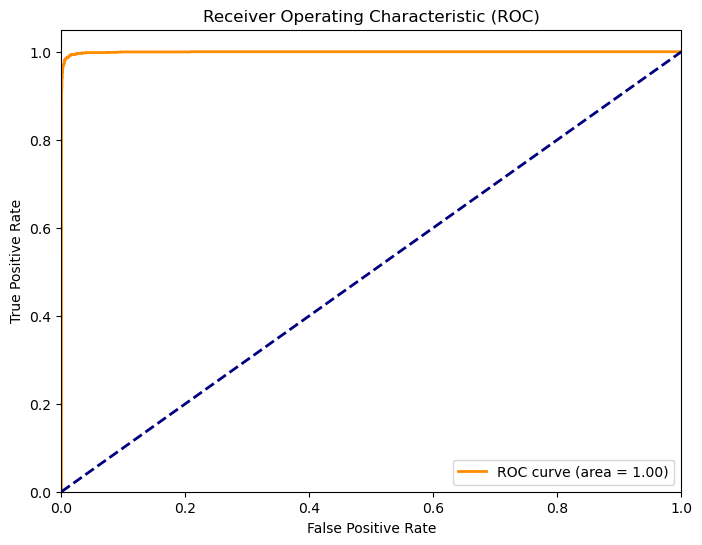

Accuracy: 0.9918
Precision: 0.9833
Recall: 0.9699
F1 Score: 0.9766
ROC-AUC Score: 0.9993


In [83]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

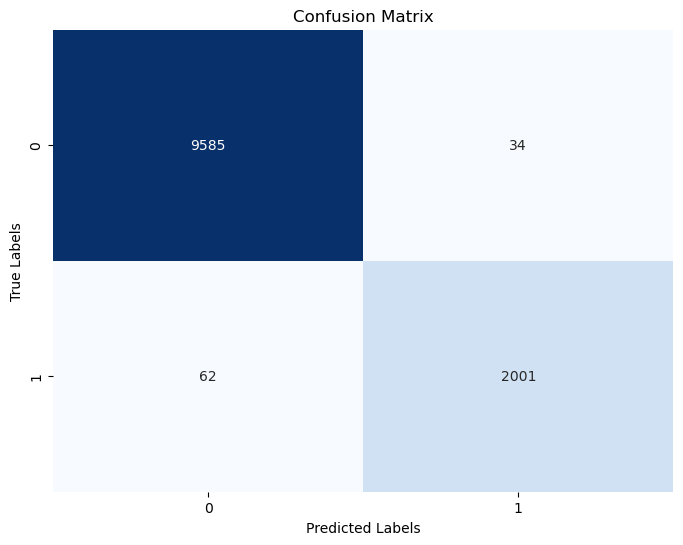

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [85]:
# Save the model
model_generic.save('generic_model_ARGvshealthy_synthetic_3.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
